In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
# from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

In [2]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


## (Logistic regression, Linear-SVM) with simple TF-IDF vectors 

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from sklearn.utils import class_weight
import spacy
from prettytable import PrettyTable as pt

In [4]:
#Creating conclusion table
conclusion_table = pt()
conclusion_table.field_names = ["Model", "Hyper Parameter", "Log-Loss"]

### Retriveing dataset

In [66]:
# avoid decoding problems
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
dfnlp['question1'] = dfnlp['question1'].apply(lambda x: str(x))
dfnlp['question2'] = dfnlp['question2'].apply(lambda x: str(x))
dfnlp = dfnlp.drop(['qid1', 'qid2'], axis=1)
dfnlp.columns

Index(['id', 'question1', 'question2', 'is_duplicate', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio'],
      dtype='object')

In [67]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
dfppro = dfppro.drop(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1)
dfppro.columns

Index(['id', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       'freq_q1-q2'],
      dtype='object')

In [68]:
df = dfnlp.merge(dfppro, on='id',how='left')
df.head()

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [69]:
df.columns

Index(['id', 'question1', 'question2', 'is_duplicate', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [76]:
df = df.sample(n=50000, replace=False, random_state=1)

### Splitting dataset and transforming in TF-IDF

In [41]:
def merge_features(q1, q2, rest_feat):
    data_set = sparse.hstack((rest_feat.values, q1, q2))
    return data_set

y_true = df['is_duplicate']
data = df.drop(['is_duplicate','id'], axis=1)

# split in train, test and cv
X, x_te , Y, y_te = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

x_tr, x_cv , y_tr, y_cv = train_test_split(X, Y, stratify=Y, test_size=0.3)

#building pipeline for faster process
tfidf_pipeline = Pipeline([
    #Bow vectorizer
    ('vect', TfidfVectorizer()),
    #Standardizing the data
    ('std', StandardScaler())
])
#Setting params for vectorizer and scalar transforms
tfidf_pipeline.set_params(vect__ngram_range=((1,2)), vect__min_df=10, vect__max_features=5000, std__with_mean=False)

#Tfidf transformation of both question pair for every row

df_q1 = X['question1']
df_q2 = X['question2']
feat_X = X.drop(['question1', 'question2'], axis=1)


#Training questions
df_q1_tr = x_tr['question1']
df_q2_tr = x_tr['question2']
feat_tr = x_tr.drop(['question1', 'question2'], axis=1)

#CV questions
df_q1_cv = x_cv['question1']
df_q2_cv = x_cv['question2']
feat_cv = x_cv.drop(['question1', 'question2'], axis=1)

#Testing questions
df_q1_te = x_te['question1']
df_q2_te = x_te['question2']
feat_te = x_te.drop(['question1', 'question2'], axis=1)

#only train data to fit the tf-idf
questions = list(df_q1_tr) + list(df_q2_tr)

#fit
tfidf_pipeline.fit(list(questions))

q1_feat = tfidf_pipeline.fit_transform(list(df_q1))
q2_feat = tfidf_pipeline.fit_transform(list(df_q2))

#Transforming train questions
q1_feat_tr = tfidf_pipeline.transform(list(df_q1_tr))
q2_feat_tr = tfidf_pipeline.transform(list(df_q2_tr))

#Transforming CV questions
q1_feat_cv = tfidf_pipeline.transform(list(df_q1_cv))
q2_feat_cv = tfidf_pipeline.transform(list(df_q2_cv))

#Transforming test questions
q1_feat_te = tfidf_pipeline.transform(list(df_q1_te))
q2_feat_te = tfidf_pipeline.transform(list(df_q2_te))

In [42]:
# merging all features together

tfidf_X = merge_features(q1_feat, q2_feat, feat_X).tocsr()
tfidf_tr = merge_features(q1_feat_tr, q2_feat_tr, feat_tr).tocsr()
tfidf_cv = merge_features(q1_feat_cv, q2_feat_cv, feat_cv).tocsr()
tfidf_te = merge_features(q1_feat_te, q2_feat_te, feat_te).tocsr()


print("Train data set size {}".format(tfidf_tr.shape))
print("Train data set values\n",y_tr.value_counts())
print("Cross validation data set size {}".format(tfidf_cv.shape))
print("Cross validation set values\n",y_cv.value_counts())
print("Test data set size {}".format(tfidf_te.shape))
print("Test data set values\n",y_te.value_counts())

Train data set size (24500, 10026)
Train data set values
 0    15529
1     8971
Name: is_duplicate, dtype: int64
Cross validation data set size (10500, 10026)
Cross validation set values
 0    6656
1    3844
Name: is_duplicate, dtype: int64
Test data set size (15000, 10026)
Test data set values
 0    9508
1    5492
Name: is_duplicate, dtype: int64


In [117]:
# qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
# unique_qs = len(np.unique(qids))
df_duplicate = df[df['is_duplicate'] == 1]
questions_duplicate = list(df[df['is_duplicate'] == 1]['question1']) + list(df[df['is_duplicate'] == 1]['question2'])
unq_duplicate_q = set(questions_duplicate)
df_duplicate.shape

(18307, 30)

In [116]:
# matrix factorization
questions = list(df['question1']) + list(df['question2'])
unq_questions = list(set(questions))
no_ques = len(unq_questions)
# len(questions)
matrix = sparse.csr_matrix((no_ques, no_ques), dtype=np.int8)

for index, df_row in df_duplicate.iterrows():
#     print(df_row['question1'] in unq_questions)
#     break
    row = unq_questions.index(df_row['question1'])
    col = unq_questions.index(df_row['question2'])
    matrix[row,col] = 1
        
# matrix[0,5] = 6
# matrix.toarray()
# matrix = np.zeros(shape=(len(set(questions)),len(set(questions))))

In [121]:
import sklearn
model = sklearn.decomposition.NMF(n_components=2, init='random', random_state=0)


In [123]:
W = model.fit_transform(matrix)
H = model.components_

In [130]:
H.shape

(2, 88994)

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
data_q1

<50000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 613317 stored elements in Compressed Sparse Row format>

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8869302838012473


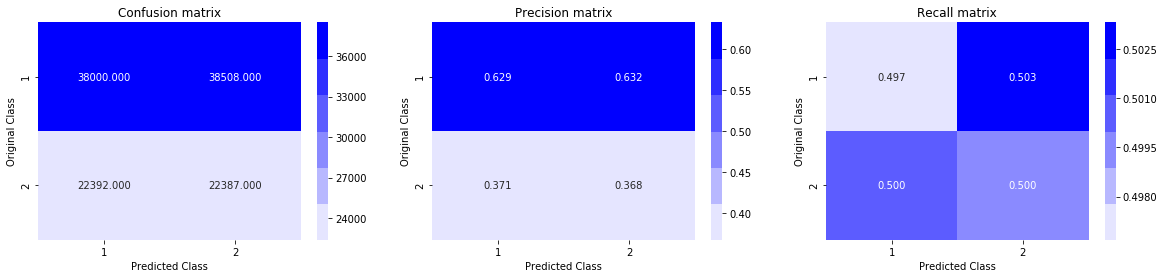

In [12]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
test_len = y_te.shape[0]
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_te, predicted_y, eps=1e-15))
conclusion_table.add_row(["Random-Model", 'None', log_loss(y_te, predicted_y, eps=1e-15)])
predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_te, predicted_y)

## Logistic Regression with hyperparameter tuning

For values of alpha =  1e-10 The log loss is: 0.6585278256632965
For values of alpha =  1e-09 The log loss is: 0.6585278256632965
For values of alpha =  1e-08 The log loss is: 0.6585278256632965
For values of alpha =  1e-07 The log loss is: 0.5466661797965934
For values of alpha =  1e-06 The log loss is: 0.40862132202214596
For values of alpha =  1e-05 The log loss is: 0.40867142652564326
For values of alpha =  0.0001 The log loss is: 0.4121483262725153
For values of alpha =  0.001 The log loss is: 0.4078489975142536
For values of alpha =  0.01 The log loss is: 0.402672560942191
For values of alpha =  0.1 The log loss is: 0.39982510645711417
For values of alpha =  1 The log loss is: 0.4394559579644053
For values of alpha =  10 The log loss is: 0.5287088639196005


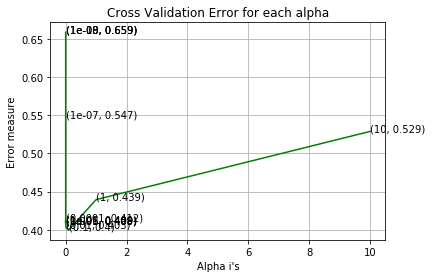

For values of best alpha =  0.1 The train log loss is: 0.37569371670605445
For values of best alpha =  0.1 The test log loss is: 0.39982510645711417
Total number of data points : 121287


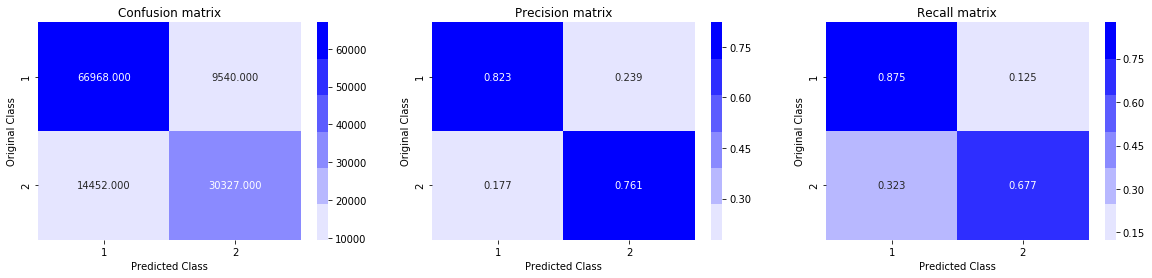

In [13]:
alpha = [10 ** x for x in range(-10, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(tfidf_tr, y_tr)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_tr, y_tr)
    predict_y = sig_clf.predict_proba(tfidf_te)
    log_error_array.append(log_loss(y_te, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_te, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(tfidf_tr, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_tr, y_tr)

predict_y = sig_clf.predict_proba(tfidf_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_te, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_te, predicted_y)
#Addiing to conclusion table
conclusion_table.add_row(["Logistic-regression", alpha[best_alpha], log_loss(y_te, predict_y, labels=clf.classes_, eps=1e-15)])

## Linear SVM with hyperparameter tuning

For values of alpha =  1e-10 The log loss is: 0.6585278256632965
For values of alpha =  1e-09 The log loss is: 0.6585278256632965
For values of alpha =  1e-08 The log loss is: 0.6585278256632965
For values of alpha =  1e-07 The log loss is: 0.6585278256632965
For values of alpha =  1e-06 The log loss is: 0.41686335449690787
For values of alpha =  1e-05 The log loss is: 0.42360765746416246
For values of alpha =  0.0001 The log loss is: 0.431793087516689
For values of alpha =  0.001 The log loss is: 0.4655113650613371
For values of alpha =  0.01 The log loss is: 0.539183722158609
For values of alpha =  0.1 The log loss is: 0.6533690837316557
For values of alpha =  1 The log loss is: 0.6582621808081434
For values of alpha =  10 The log loss is: 0.6510147291799161


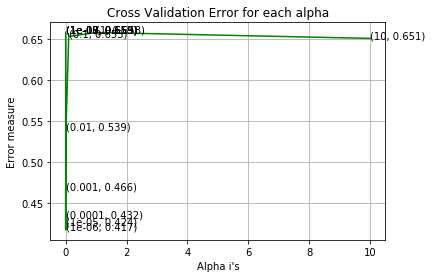

For values of best alpha =  1e-06 The train log loss is: 0.3783858379628486
For values of best alpha =  1e-06 The test log loss is: 0.41686335449690787
Total number of data points : 121287


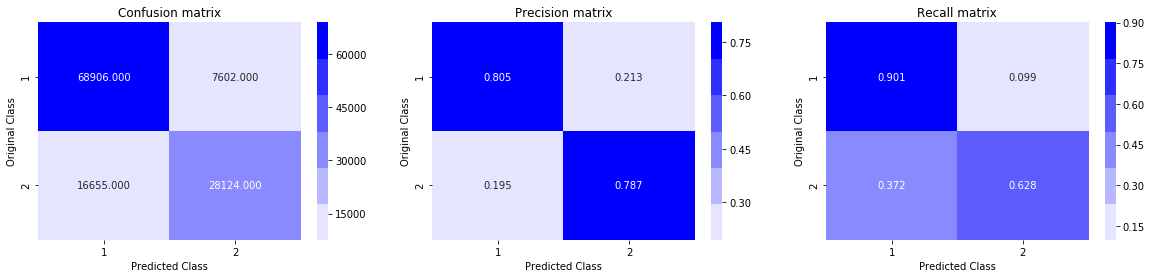

In [14]:
alpha = [10 ** x for x in range(-10, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(tfidf_tr, y_tr)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_tr, y_tr)
    predict_y = sig_clf.predict_proba(tfidf_te)
    log_error_array.append(log_loss(y_te, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_te, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(tfidf_tr, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_tr, y_tr)

predict_y = sig_clf.predict_proba(tfidf_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_te, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_te, predicted_y)
conclusion_table.add_row(["Linear-SVM", alpha[best_alpha], log_loss(y_te, predict_y, labels=clf.classes_, eps=1e-15)])

### Words2vec for xgboost

In [15]:
# from tqdm import tqdm_notebook as tqdm
# word2tfidf = dict(zip(tfidf_pipeline.named_steps['vect'].get_feature_names(), tfidf_pipeline.named_steps['vect'].idf_))
# nlp = spacy.load('en_core_web_sm')

# def word2vec(questions_list, word2tfidf):
#     vecs1 = []
#     # nlp(x_tr['question1'][:10].values[0])
#     # https://github.com/noamraph/tqdm
#     # tqdm is used to print the progress bar
#     for qu1 in tqdm(questions_list):
#         doc1 = nlp(qu1)
#         # 384 is the number of dimensions of vectors 
#         mean_vec1 = np.zeros([doc1.tensor.shape[0],doc1.tensor.shape[1]])
#         for word1 in doc1:
#             # word2vec
#             vec1 = word1.vector

#             # fetch df score
#             try:
#                 idf = word2tfidf[str(word1)]
#             except:
#                 idf = 0
#             # compute final vec
#             mean_vec1 += vec1 * idf
#         mean_vec1 = mean_vec1.mean(axis=0)
#         vecs1.append(mean_vec1)
#     return np.array(vecs1)

In [16]:
# #Word 2vec
# w2v_tr = word2vec(list(x_tr['question1']), word2tfidf)
# w2v_cv = word2vec(list(x_cv['question1']), word2tfidf)
# w2v_te = word2vec(list(x_te['question1']), word2tfidf)

In [17]:
# print("Train w2v size {}".format(w2v_tr.shape))
# print("Cross validation w2v size {}".format(w2v_cv.shape))
# print("Test w2v size {}".format(w2v_te.shape))

In [18]:
# # merging all features together

# w2v_tr = sparse.hstack((feat_tr, w2v_tr)).tocsr()
# w2v_cv = sparse.hstack((feat_cv, w2v_cv)).tocsr()
# w2v_te = sparse.hstack((feat_te, w2v_te)).tocsr()


# print("Train data set size {}".format(w2v_tr.shape))
# print("Train data set values\n",y_tr.value_counts())
# print("Cross validation data set size {}".format(w2v_cv.shape))
# print("Cross validation set values\n",y_cv.value_counts())
# print("Test data set size {}".format(w2v_te.shape))
# print("Test data set values\n",y_te.value_counts())

## XGBoost with hyper paramter tuning

In [19]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
max_depth  = [1*x for x in range(2, 10)]
loss_cv = []
loss_tr = []
for t_depth in max_depth:
    params['max_depth'] = t_depth
    print("TRAINING ON DEPTH",t_depth)
    d_tr = xgb.DMatrix(tfidf_tr, label=y_tr)
    d_cv = xgb.DMatrix(tfidf_cv, label=y_cv)

    watchlist = [(d_tr, 'train'), (d_cv, 'validation')]

    bst = xgb.train(params, d_tr, 700, watchlist, early_stopping_rounds=20, verbose_eval=200)

#     xgdmat = xgb.DMatrix(w2v_tr,y_tr)
    predict_y_tr = bst.predict(d_tr)
    predict_y_cv = bst.predict(d_cv)
    print("The CV log loss is:",log_loss(y_cv, predict_y_cv, labels=clf.classes_, eps=1e-15))
    loss_tr.append(bst.eval_set(watchlist).split()[1].split(':')[1]) 
    loss_cv.append(bst.eval_set(watchlist).split()[2].split(':')[1])

TRAINING ON DEPTH 2
[0]	train-logloss:0.686786	validation-logloss:0.686749
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 20 rounds.
[200]	train-logloss:0.424402	validation-logloss:0.423075
[400]	train-logloss:0.391608	validation-logloss:0.390561
[600]	train-logloss:0.379189	validation-logloss:0.378205
[699]	train-logloss:0.375036	validation-logloss:0.37414
The CV log loss is: 0.37413953548975604
TRAINING ON DEPTH 3
[0]	train-logloss:0.685341	validation-logloss:0.685312
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 20 rounds.
[200]	train-logloss:0.390298	validation-logloss:0.389014
[400]	train-logloss:0.368215	validation-logloss:0.367391
[600]	train-logloss:0.358762	validation-logloss:0.358457
[699]	train-logloss:0.35521	validation-logloss:0.355191
The CV log loss is: 0.355191252320

In [26]:
loss_cv

['0.374140',
 '0.355191',
 '0.344340',
 '0.336268',
 '0.330533',
 '0.325315',
 '0.321418',
 '0.317723']

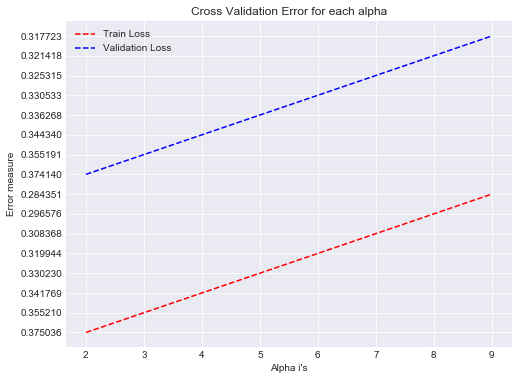

In [37]:
plt.close
sns.set_style("darkgrid")
plt.figure(figsize=(8,6))
plt.plot(max_depth,loss_tr,'r--',label='Train Loss')
plt.plot(max_depth,loss_cv,'b--',label='Validation Loss')
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.legend()
plt.show()


In [21]:
# Running on test set to get final score
params['max_depth'] = 7

d_tr = xgb.DMatrix(tfidf_tr, label=y_tr)
d_te = xgb.DMatrix(tfidf_te, label=y_te)

watchlist = [(d_tr, 'train'), (d_te, 'test')]

bst = xgb.train(params, d_tr, 700, watchlist, early_stopping_rounds=20, verbose_eval=200)

predict_y_te = bst.predict(d_te)
print("The test log loss is:",log_loss(y_te, predict_y_te, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.683379	test-logloss:0.683407
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 20 rounds.
[200]	train-logloss:0.340915	test-logloss:0.34893
[400]	train-logloss:0.322361	test-logloss:0.335362
[600]	train-logloss:0.312074	test-logloss:0.329038
[699]	train-logloss:0.308368	test-logloss:0.327024
The test log loss is: 0.3270234856736916


Total number of data points : 121287


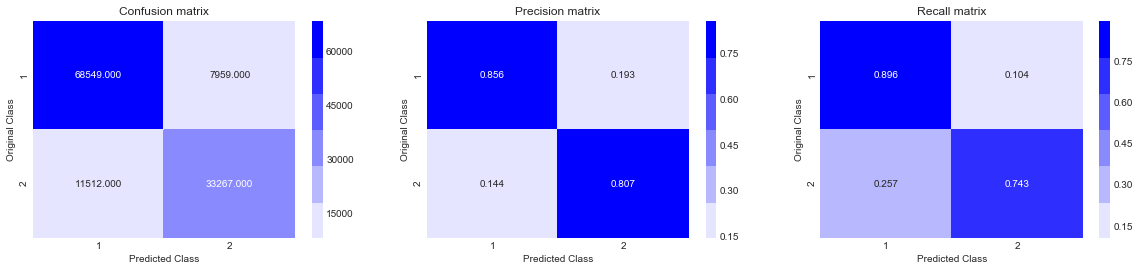

In [22]:
predicted_y =np.array(predict_y_te>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_te, predicted_y)
conclusion_table.add_row(["XGBoost", 7, log_loss(y_te, predict_y_te, labels=clf.classes_, eps=1e-15)])

### Conclusion

In [23]:
#conclusion
print(conclusion_table)

+---------------------+-----------------+---------------------+
|        Model        | Hyper Parameter |       Log-Loss      |
+---------------------+-----------------+---------------------+
|     Random-Model    |       None      |  0.8869302838012473 |
| Logistic-regression |       0.1       | 0.39982510645711417 |
|      Linear-SVM     |      1e-06      | 0.41686335449690787 |
|       XGBoost       |        7        |  0.3270234856736916 |
+---------------------+-----------------+---------------------+


In [24]:
# Conclusion 

### linear models perform best when giveb high deminsion data

### linear model like logsitic regression and linear svm where still observed being underfitted so, either create more feature
# or, use more complex models like xgboost, rbf svm, Random forest but rbf_svm and RF is computationally expensive so we use xgboost

### xgboost on w2v performed well than simple linear models

### xgboost on tfidf perfermed well than xgboost on w2v cause it has high dim data
